In [1]:
import os
import numpy as np
import pandas as pd
import nrrd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi
mca = MouseConnectivityApi()
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [2]:
import platform
if platform.system() == 'Windows':
    basepath = r'C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress\2019 DMN'
elif platform.system() == 'Darwin':
    basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'

In [18]:
td_glm_dat = pd.read_csv(os.path.join(basepath, 
                                       'data_files', 
                                       'td_ctx_injections_DMN_and_core_projections_coefficients.csv'))
ctx_coord_dat = pd.read_csv(os.path.join(basepath, 
                                         'data_files',
                                         'cortical_flatmap_coordinates.csv'))
print(len(td_glm_dat))

121


In [4]:
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
RSPv = structure_tree.get_structures_by_acronym(['RSPv'])[0]

In [12]:
RSPv_exps = pd.DataFrame(mcc.get_experiments(cre=['Ai75(RCL-nT)'], 
                                             injection_structure_ids = [RSPv['id']]))
print(len(RSPv_exps))

21


In [22]:
rspc = RSPv_exps[RSPv_exps['id'].isin([521255975, 561511939, 569904687, 592522663, 
                                       592724077, 623838656, 664716091, 666090944, 
                                       868641659])]

In [23]:
rspc = rspc.merge(td_glm_dat[['id', 'injection dmn fraction', 
                                       'projection dmn fraction',
                                      'DMN coefficient']], on = 'id')
rspc = rspc.merge(ctx_coord_dat[['id', 
                                         'top_x', 
                                       'top_y']], on = 'id',
                         how = 'left')
rspc.rename(columns = {'DMN coefficient': 'DMN_coefficient'}, inplace = True)
print(len(rspc))

8


In [24]:
rostral = int(rspc['injection_x'].min()/25)
caudal = int(rspc['injection_x'].max()/25)
print(rostral)
print(caudal)

332
346


In [25]:
def make_mask(mask, axis):
    mask = scipy.ndimage.filters.gaussian_filter(mask, 1, order = 0)
    mask = scipy.ndimage.zoom(mask, 4, order=2)
    if axis == 'horizontal':
        mask = mask.max(axis = 1)
    elif axis == 'sagittal':
        mask = mask[:,:,228:]
        mask = mask.max(axis = 2)
    elif axis == 'axial':
        mask = mask[rostral:caudal,:,:]
        mask = mask.max(axis = 0)
    elif axis == 'section':
        mask[np.where(mask < -0.1)] = np.nan
        
    return mask

In [26]:
template, _ = mcc.get_template_volume()
template_ax = np.percentile(template[rostral:caudal,:,:], axis = 0, q=90)
template_sag = np.percentile(template[:,:,:170], axis = 2, q=100)
template_sag_L = np.fliplr(template_sag)

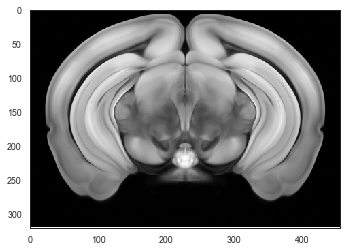

In [27]:
plt.imshow(template_ax, cmap = 'gray')

In [28]:
savepath = os.path.join(basepath, '_new_figures', 'Figure_6')

In [30]:
import imageio
cortical_background_img_path = os.path.join(basepath, '_new_figures', 'Figure_2')
imb = imageio.imread(os.path.join(cortical_background_img_path, 
                                  'DMN_cortical_projection_boundaries.png'))

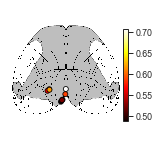

In [32]:
rspc.sort_values(by='injection_volume', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(rspc.top_x,
           rspc.top_y,
           c = rspc['projection dmn fraction'],
           edgecolor = 'k',
           s = 25,
           cmap = 'hot')
cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, 
                    pad=-0.01)

cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)

plt.savefig(os.path.join(savepath, 'RSPv_caudal_injs_on_ctx.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

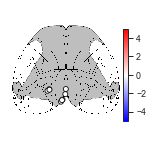

In [33]:
rspc.sort_values(by='injection_volume', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(rspc.top_x,
           rspc.top_y,
           c = rspc['DMN_coefficient'],
           edgecolor = 'k',
           s = 25,
           cmap = 'bwr',
                vmax = 5,
                 vmin = -5)
cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, 
                    pad=-0.01)
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)

plt.savefig(os.path.join(savepath, 'RSPv_caudal_injections_on_DMN_ctx_dmn_coefficient.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [34]:
both_dmn_masks, _ = nrrd.read(os.path.join(basepath, 
                                           'fMRI_masks',
                                           'dmn_mask_and_core.nrrd'))
print(np.unique(both_dmn_masks))
dmn_mask = np.zeros(both_dmn_masks.shape)
dmn_mask[np.where(both_dmn_masks > 0)] = 1
mask = make_mask(dmn_mask, 'axial')
core_mask = np.zeros(both_dmn_masks.shape)
core_mask[np.where(both_dmn_masks == 2)] = 1
core = make_mask(core_mask, 'axial')

[0. 1. 2.]


In [35]:
import colormap
c = colormap.Colormap()
white_cmap = c.cmap_linear('black','white', 'white')
gray_cmap = c.cmap_linear('black', 'DarkGray', 'LightGray')
dark_cmap = c.cmap_linear('black', 'black', 'DarkGray')

In [45]:
rspc.loc[rspc['id'].isin([592522663, 623838656]), 'color'] = 'm'
rspc.loc[rspc['id'].isin([521255975, 561511939]), 'color'] = 'c'
rspc.loc[rspc['id'].isin([569904687, 868641659]), 'color'] = 'lime'

In [47]:
pltdat

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,...,transgenic_line,transgenic_line_id,id,primary_injection_structure,injection dmn fraction,projection dmn fraction,DMN_coefficient,top_x,top_y,color
4,F,"[879, 886]",0.033392,8590,1240,4550,44,Ai75(T503)-291434,unknown,RSPv,...,Ai75(RCL-nT),299863660,569904687,879,0.761261,0.511667,-0.000649,537.0,900.0,lime
1,M,[886],0.000518,8520,1610,4560,44,Ai75(T503)-313793,None,RSPv,...,Ai75(RCL-nT),299863660,592522663,886,0.303147,0.619385,-0.000002,410.0,804.0,m
0,F,[886],0.002652,8370,1670,4630,44,Ai75(T503)-338171,None,RSPv,...,Ai75(RCL-nT),299863660,623838656,886,0.000571,0.562507,-0.000015,391.0,814.0,m
5,M,[886],0.005104,8340,1610,5000,44,Ai75(T601)-276538,unknown,RSPv,...,Ai75(RCL-nT),299863660,561511939,886,0.399288,0.708294,0.000026,569.0,797.0,c
2,M,"[886, 1037]",0.005848,8320,1680,4870,44,Ai75(T503)-215057,None,RSPv,...,Ai75(RCL-nT),299863660,521255975,886,0.053660,0.600392,-0.000052,408.0,799.0,c


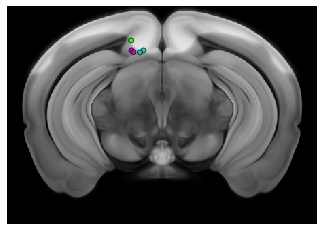

In [46]:
pltdat = rspc[~rspc['color'].isnull()]
fig,ax = plt.subplots(1,1)
ax.imshow(template_ax, cmap = 'gray')
ax.imshow(mask, cmap = white_cmap, alpha = 0.7)
ax.imshow(template_ax, cmap = 'gray', alpha = 0.6)
cax = ax.scatter(pltdat.injection_z/25,
           pltdat.injection_y/25,
           c = pltdat['color'],
           edgecolor = 'k',
           s = 25,
           cmap = 'hot',
                alpha = 0.8)
plt.axis('off')

plt.savefig(os.path.join(savepath, 'RSPv_caudal_injections_on_DMN_ax_inj_fraction.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

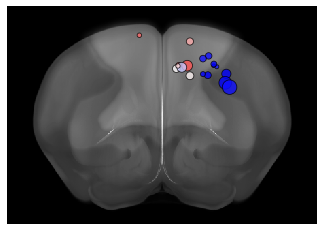

In [34]:
MOs_exps.sort_values(by='injection_x', ascending = False, inplace = True)

fig,ax = plt.subplots(1,1)
ax.imshow(template_ax, cmap = 'gray')
ax.imshow(mask, cmap = white_cmap, alpha = 0.6)
ax.imshow(core, cmap = dark_cmap, alpha = 0.6)
ax.imshow(template_ax, cmap = 'gray', alpha = 0.7)
cax = ax.scatter(MOs_exps.injection_z/25,
           MOs_exps.injection_y/25,
           c = MOs_exps['DMN_coefficient'],
           edgecolor = 'k',
           s = MOs_exps.injection_volume.values*200,
           cmap = 'bwr',
                vmax = 5,
                 vmin = -5,
                alpha = 0.8)
plt.axis('off')

plt.savefig(os.path.join(savepath, 'wt_injections_on_DMN_ax_dmn_coefficient.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

In [35]:
mask_sag = make_mask(dmn_mask, 'sagittal')
core_sag = make_mask(core_mask, 'sagittal')

In [36]:
template_sag.shape

(528, 320)

(-0.5, 319.5, 527.5, -0.5)

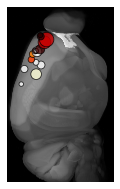

In [21]:
MOs_exps.sort_values(by='injection_x', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(template_sag, cmap = 'gray')
ax.imshow(mask_sag, cmap = white_cmap, alpha = 0.6)
ax.imshow(core_sag, cmap = dark_cmap, alpha = 0.6)
ax.imshow(template_sag, cmap = 'gray', alpha = 0.7)
cax = ax.scatter(MOs_exps.injection_y/25,
           MOs_exps.injection_x/25,
           c = MOs_exps['injection_percent_dmn'],
           edgecolor = 'k',
           s = MOs_exps.injection_volume.values*200,
           cmap = 'hot',
                alpha = 0.8)
fig.set_size_inches(1.95,3.22)
plt.axis('off')

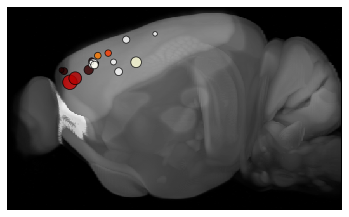

In [22]:
MOs_exps.sort_values(by='injection_z', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(np.flipud(scipy.ndimage.rotate(template_sag, 90)), cmap = 'gray')
ax.imshow(np.flipud(scipy.ndimage.rotate(mask_sag, 90)), cmap = white_cmap, alpha = 0.6)
ax.imshow(np.flipud(scipy.ndimage.rotate(core_sag, 90)), cmap = dark_cmap, alpha = 0.6)
ax.imshow(np.flipud(scipy.ndimage.rotate(template_sag, 90)), cmap = 'gray', alpha = 0.7)
cax = ax.scatter(MOs_exps.injection_x/25,
           MOs_exps.injection_y/25,
           c = MOs_exps['injection_percent_dmn'],
           edgecolor = 'k',
           s = MOs_exps.injection_volume.values*200,
           cmap = 'hot',
                alpha = 0.8)
plt.axis('off')
plt.savefig(os.path.join(savepath, 'wt_injections_on_DMN_sag_inj_fraction.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

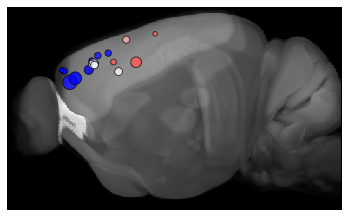

In [23]:
MOs_exps.sort_values(by='injection_z', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(np.flipud(scipy.ndimage.rotate(template_sag, 90)), cmap = 'gray')
ax.imshow(np.flipud(scipy.ndimage.rotate(mask_sag, 90)), cmap = white_cmap, alpha = 0.6)
ax.imshow(np.flipud(scipy.ndimage.rotate(core_sag, 90)), cmap = dark_cmap, alpha = 0.6)
ax.imshow(np.flipud(scipy.ndimage.rotate(template_sag, 90)), cmap = 'gray', alpha = 0.7)
cax = ax.scatter(MOs_exps.injection_x/25,
           MOs_exps.injection_y/25,
           c = MOs_exps['DMN_coefficient'],
           edgecolor = 'k',
           s = MOs_exps.injection_volume.values*200,
           cmap = 'bwr',
                vmax = 5,
                 vmin = -5,
                alpha = 0.8)
plt.axis('off')
#fig.set_size_inches(2.5,2.5)

plt.savefig(os.path.join(savepath, 'wt_injections_on_DMN_sag_DMN_coeff.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

In [39]:
import colormap
c = colormap.Colormap()
all_green_cmap = c.cmap_linear('green', 'green', 'green')
green_cmap = c.cmap_linear('black', 'green', 'lightgreen')
orangered_cmap = c.cmap_linear('black', 'red', 'orangered')
red_cmap = c.cmap_linear('black', 'darkred', 'orangered')
light_red_cmap = c.cmap_linear('black', 'crimson', 'white')
white_cmap = c.cmap_linear('black','white', 'white')
gray_cmap = c.cmap_linear('black', 'black', 'LightGray')
dark_cmap = c.cmap_linear('black', 'black', 'DarkGray')

In [40]:
image_mask = make_mask(dmn_mask, 'section')
core_mask = make_mask(core_mask, 'section')

In [41]:
isid = 141603190 #in 166055636 # in with low DMN coefficient 
inj_den, _ = mcc.get_injection_density(isid)
proj_den, _ = mcc.get_projection_density(isid)
data_mask, _ = mcc.get_data_mask(isid)

In [47]:
# Injection
density = np.copy(inj_den)
invalid = np.logical_not(data_mask)
density[invalid] = 0
max_signal = []
for ix in np.unique(np.nonzero(density)):
    max_signal.append([ix, np.count_nonzero(density[ix])])
    if max_signal != []:
        maxi = []
        maxs = 0
        for ij in max_signal:
            if ij[1] > maxs:
                maxs = ij[1]
                maxi = ij[0]
print(maxi)

167


In [48]:
density[density < 0.01] = np.nan

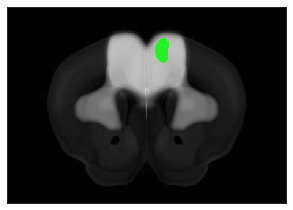

In [49]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(template[maxi], cmap='gray', interpolation = 'none')
ax.imshow(core_mask[maxi], cmap = white_cmap, alpha = 0.5)
ax.imshow(image_mask[maxi], cmap = gray_cmap, alpha = 0.4)
ax.imshow(density[maxi], cmap = all_green_cmap, alpha = 0.8)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
filename = os.path.join(savepath, 'MOs_'+'injection_'+str(isid)+'_'+str(maxi)+'.pdf')
plt.savefig(filename, dpi=300, bbox_inches='tight')

In [45]:
# Projection
density = np.copy(proj_den)
invalid = np.logical_not(data_mask)
density[invalid] = 0
max_signal = []
for ix in np.unique(np.nonzero(density)):
    max_signal.append([ix, np.count_nonzero(density[ix])])
    if max_signal != []:
        maxi = []
        maxs = 0
        for ij in max_signal:
            if ij[1] > maxs:
                maxs = ij[1]
                maxi = ij[0]
print(maxi) 

265


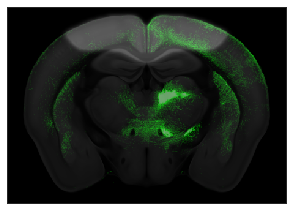

In [46]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(image_mask[maxi], cmap = gray_cmap)
ax.imshow(template[maxi], cmap='gray', interpolation = 'none', alpha = 0.8)
ax.imshow(core_mask[maxi], cmap = white_cmap, alpha = 0.5)
ax.imshow(density[maxi], cmap = green_cmap, alpha = 0.6)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
filename = os.path.join(savepath, 'MOs_'+'projection_'+str(isid)+'_'+str(maxi)+'.pdf')
plt.savefig(filename, dpi=300, bbox_inches='tight')

In [50]:
isid = 585025284 #out
inj_den, _ = mcc.get_injection_density(isid)
proj_den, _ = mcc.get_projection_density(isid)
data_mask, _ = mcc.get_data_mask(isid)

In [51]:
# Injection
density = np.copy(inj_den)
invalid = np.logical_not(data_mask)
density[invalid] = 0
max_signal = []
for ix in np.unique(np.nonzero(density)):
    max_signal.append([ix, np.count_nonzero(density[ix])])
    if max_signal != []:
        maxi = []
        maxs = 0
        for ij in max_signal:
            if ij[1] > maxs:
                maxs = ij[1]
                maxi = ij[0]
print(maxi)

144


In [52]:
density[density < 0.01] = np.nan

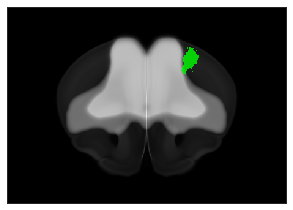

In [54]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(template[maxi], cmap='gray', interpolation = 'none')
ax.imshow(core_mask[maxi], cmap = white_cmap, alpha = 0.5)
ax.imshow(image_mask[maxi], cmap = gray_cmap, alpha = 0.4)
ax.imshow(density[maxi], cmap = all_green_cmap, alpha = 0.8)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
filename = os.path.join(savepath, 'MOs_'+'injection_'+str(isid)+'_'+str(maxi)+'.pdf')
plt.savefig(filename, dpi=300, bbox_inches='tight')

In [55]:
# Projection
density = np.copy(proj_den)
invalid = np.logical_not(data_mask)
density[invalid] = 0
max_signal = []
for ix in np.unique(np.nonzero(density)):
    max_signal.append([ix, np.count_nonzero(density[ix])])
    if max_signal != []:
        maxi = []
        maxs = 0
        for ij in max_signal:
            if ij[1] > maxs:
                maxs = ij[1]
                maxi = ij[0]
print(maxi) 

181


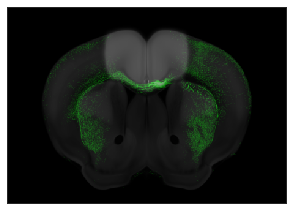

In [76]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(image_mask[maxi], cmap = gray_cmap)
ax.imshow(template[maxi], cmap='gray', interpolation = 'none', alpha = 0.8)
ax.imshow(core_mask[maxi], cmap = white_cmap, alpha = 0.3)
ax.imshow(density[maxi], cmap = green_cmap, alpha = 0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
filename = os.path.join(savepath, 'MOs_'+'projection_'+str(isid)+'_'+str(maxi)+'.pdf')
plt.savefig(filename, dpi=300, bbox_inches='tight')

In [40]:
MOs_exps.keys()

Index(['gender', 'injection_structures', 'injection_volume', 'injection_x',
       'injection_y', 'injection_z', 'product_id', 'specimen_name', 'strain',
       'structure_abbrev', 'structure_id', 'structure_name', 'transgenic_line',
       'transgenic_line_id', 'id', 'primary_injection_structure',
       'injection dmn fraction', 'projection dmn fraction', 'DMN_coefficient',
       'top_x', 'top_y', 'percent_dmn', 'injection_percent_dmn'],
      dtype='object')

## Plot one experiment at a time

In [39]:
#isid = 166055636 # Fig. S2 top
#isid = 141603190 # Fig. S2 middle
isid = 585025284 # Fig. S2 bottom

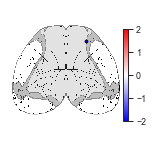

In [40]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(MOs_exps[MOs_exps['id'] == isid]['top_x'],
           MOs_exps[MOs_exps['id'] == isid]['top_y'],
           c = MOs_exps[MOs_exps['id'] == isid]['DMN_coefficient'],
           edgecolor = 'k',
           s = MOs_exps[MOs_exps['id'] == isid]['injection_volume'].values*50,
           cmap = 'bwr',
                vmax = 2,
                 vmin = -2)
cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, 
                    pad=-0.01)
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)
plt.savefig(os.path.join(savepath, '{0}_on_DMN_ctx.pdf'.format(isid)), 
            layout='tight', 
            pad_inches=0.3, 
            format='pdf', 
            transparent=True, 
            dpi=300)
            

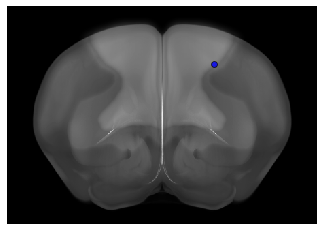

In [41]:
MOs_exps.sort_values(by='injection_x', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(template_ax, cmap = 'gray')
ax.imshow(mask, cmap = white_cmap, alpha = 0.6)
ax.imshow(core, cmap = dark_cmap, alpha = 0.6)
ax.imshow(template_ax, cmap = 'gray', alpha = 0.7)
cax = ax.scatter(MOs_exps[MOs_exps['id'] == isid]['injection_z']/25,
           MOs_exps[MOs_exps['id'] == isid]['injection_y']/25,
           c = MOs_exps[MOs_exps['id'] == isid]['DMN_coefficient'],
           edgecolor = 'k',
           s = MOs_exps[MOs_exps['id'] == isid]['injection_volume'].values*200,
           cmap = 'bwr',
                vmax = 2,
                 vmin = -2,
                alpha = 0.8)
plt.axis('off')

plt.savefig(os.path.join(savepath, '{0}_DMN_ax.pdf'.format(isid)), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

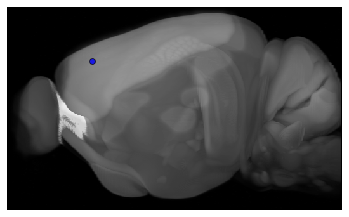

In [42]:
MOs_exps.sort_values(by='injection_x', ascending = False, inplace = True)
fig,ax = plt.subplots(1,1)
ax.imshow(np.flipud(scipy.ndimage.rotate(template_sag, 90)), cmap = 'gray')
ax.imshow(np.flipud(scipy.ndimage.rotate(mask_sag, 90)), cmap = white_cmap, alpha = 0.6)
ax.imshow(np.flipud(scipy.ndimage.rotate(core_sag, 90)), cmap = dark_cmap, alpha = 0.6)
ax.imshow(np.flipud(scipy.ndimage.rotate(template_sag, 90)), cmap = 'gray', alpha = 0.7)
cax = ax.scatter(MOs_exps[MOs_exps['id'] == isid].injection_x/25,
           MOs_exps[MOs_exps['id'] == isid].injection_y/25,
           c = MOs_exps[MOs_exps['id'] == isid]['DMN_coefficient'],
           edgecolor = 'k',
           s = MOs_exps[MOs_exps['id'] == isid].injection_volume.values*200,
           cmap = 'bwr',
                vmax = 2,
                 vmin = -2,
                alpha = 0.8)
ax.set_aspect('equal')
plt.axis('off')
plt.savefig(os.path.join(savepath, '{0}_DMN_sag.pdf'.format(isid)), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [43]:
MOs_exps['injection_x'].min()
MOs_exps['injection_x'].max()

5820

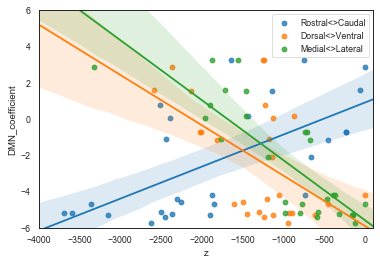

In [44]:
pltdat = MOs_exps[['injection_x', 'injection_y', 'injection_z', 'DMN_coefficient']].copy()
pltdat['x'] = pltdat['injection_x'] - pltdat['injection_x'].max()
pltdat['y'] = pltdat['injection_y'] - pltdat['injection_y'].max()
pltdat['z'] = pltdat['injection_z'] - pltdat['injection_z'].max()
fig, ax = plt.subplots()
ax.set_xlim([-4000, 100])
ax.set_ylim([-6, 6])
ax = sns.regplot(x = 'x', y = 'DMN_coefficient', data = pltdat, label = 'Rostral<>Caudal')
ax = sns.regplot(x = 'y', y = 'DMN_coefficient', data = pltdat, label = 'Dorsal<>Ventral')
ax = sns.regplot(x = 'z', y = 'DMN_coefficient', data = pltdat, label = 'Medial<>Lateral')
plt.legend()